Deep Learning
=============

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labelled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [2]:
url = 'http://commondatastorage.googleapis.com/books1000/'

def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified notMNIST_large.tar.gz
Found and verified notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labelled A through J.

In [3]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

notMNIST_large already present - Skipping extraction of notMNIST_large.tar.gz.
['notMNIST_large/A', 'notMNIST_large/B', 'notMNIST_large/C', 'notMNIST_large/D', 'notMNIST_large/E', 'notMNIST_large/F', 'notMNIST_large/G', 'notMNIST_large/H', 'notMNIST_large/I', 'notMNIST_large/J']
notMNIST_small already present - Skipping extraction of notMNIST_small.tar.gz.
['notMNIST_small/A', 'notMNIST_small/B', 'notMNIST_small/C', 'notMNIST_small/D', 'notMNIST_small/E', 'notMNIST_small/F', 'notMNIST_small/G', 'notMNIST_small/H', 'notMNIST_small/I', 'notMNIST_small/J']


In [4]:
print(train_folders)

['notMNIST_large/A', 'notMNIST_large/B', 'notMNIST_large/C', 'notMNIST_large/D', 'notMNIST_large/E', 'notMNIST_large/F', 'notMNIST_large/G', 'notMNIST_large/H', 'notMNIST_large/I', 'notMNIST_large/J']


In [5]:
print(test_folders)

['notMNIST_small/A', 'notMNIST_small/B', 'notMNIST_small/C', 'notMNIST_small/D', 'notMNIST_small/E', 'notMNIST_small/F', 'notMNIST_small/G', 'notMNIST_small/H', 'notMNIST_small/I', 'notMNIST_small/J']


---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

Get the version of the IPython package, just to be sure.

In [6]:
import IPython
print("IPython version:", IPython.__version__)

IPython version: 4.1.1


I'm not familiar with `display` function and `Image` class from `IPython.display` package so let's get some help.

In [7]:
help(IPython.display.display)

Help on function display in module IPython.core.display:

display(*objs, **kwargs)
    Display a Python object in all frontends.
    
    By default all representations will be computed and sent to the frontends.
    Frontends can decide which representation is used and how.
    
    Parameters
    ----------
    objs : tuple of objects
        The Python objects to display.
    raw : bool, optional
        Are the objects to be displayed already mimetype-keyed dicts of raw display data,
        or Python objects that need to be formatted before display? [default: False]
    include : list or tuple, optional
        A list of format type strings (MIME types) to include in the
        format data dict. If this is set *only* the format types included
        in this list will be computed.
    exclude : list or tuple, optional
        A list of format type strings (MIME types) to exclude in the format
        data dict. If this is set all format types will be computed,
        except for 

In [8]:
help(IPython.display.Image)

Help on class Image in module IPython.core.display:

class Image(DisplayObject)
 |  Method resolution order:
 |      Image
 |      DisplayObject
 |      __builtin__.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, data=None, url=None, filename=None, format=None, embed=None, width=None, height=None, retina=False, unconfined=False, metadata=None)
 |      Create a PNG/JPEG image object given raw data.
 |      
 |      When this object is returned by an input cell or passed to the
 |      display function, it will result in the image being displayed
 |      in the frontend.
 |      
 |      Parameters
 |      ----------
 |      data : unicode, str or bytes
 |          The raw image data or a URL or filename to load the data from.
 |          This always results in embedded image data.
 |      url : unicode
 |          A URL to download the data from. If you specify `url=`,
 |          the image data will not be embedded unless you also specify `embed=True`.
 |      filename : 

Let's test the usage of `Image` and `display`

In [9]:
display(Image("notMNIST_small/A/MlJlYmVsc0RldXgtQmxhY2sub3Rm.png"))

Create a function to display one random image from each folder of the input parameter.

In [10]:
def displayRandomImages(folders):
    # loop through all the folder inside the array `folders`
    for folder in folders:
        # `listdir` returns a list containing the names of the entries in the directory `folder`
        # `np.random.choice` takes one random file from the list of files in `folder` and returns a list with only one element. 
        image_filename = np.random.choice(os.listdir(folder), 1)[0]
        # `os.path.join` joins the pathname `folder` and the filename of the image, with a '/' between.
        image_path = os.path.join(folder, image_filename)
        print("Image",image_path)
        display(Image(image_path))

In [11]:
displayRandomImages(test_folders)

Image notMNIST_small/A/Q0NTcG9va3l0b290aC1SZWd1bGFyLnR0Zg==.png


Image notMNIST_small/B/Q29vcEZvcmdlZC5wZmI=.png


Image notMNIST_small/C/QmlsYm9EaXNwbGF5IEJvbGQgSXRhbGljLnR0Zg==.png


Image notMNIST_small/D/Q29uY29yZGlhU1NLIEJvbGQudHRm.png


Image notMNIST_small/E/RGFzaCBEb3QgQlJLLnR0Zg==.png


Image notMNIST_small/F/Q2FyZGluYWwgUmVndWxhci50dGY=.png


Image notMNIST_small/G/RHluYW1vUmNJdGFsaWNSQy5vdGY=.png


Image notMNIST_small/H/Q29yYmVpIFVuY2lhbC50dGY=.png


Image notMNIST_small/I/QnJ1c2hTY3JpcHRCVC1SZWd1bGFyLm90Zg==.png


Image notMNIST_small/J/SG9ybnB5cGVJVENTdGQub3Rm.png


----
Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

In [14]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, minimum_number_of_images_per_class):
  """Load the data for a single letter label."""
  image_filenames = os.listdir(folder)
    
  # Create a bidimensional array of float32 (image_size X image_size) of the size of the number of images in the current folder.
  dataset = np.ndarray(shape=(len(image_filenames), image_size, image_size), dtype=np.float32)
  image_index = 0
  
  # Walk through all the images in the current folder
  for image_filename in image_filenames:
    full_image_filename = os.path.join(folder, image_filename)
    try:
      # Load the current image and normalize it between [-0.5; 0.5]
      image_data = (ndimage.imread(full_image_filename).astype(float) - pixel_depth / 2) / pixel_depth
      
      # Test if the image dimensions are squarred and are the same as the expected size
      if image_data.shape != (image_size, image_size):
        # The image dimensions are unexpected to stop the process
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      
      # Store the image in the dataset array 
      dataset[image_index, :, :] = image_data
      image_index += 1
    except IOError as e:
      print('Could not read:', full_image_filename, ':', e, '- it\'s ok, skipping.')
    
  current_number_of_images = image_index
  dataset = dataset[0:current_number_of_images, :, :]
    
  # Test if the current_number_of_images reached the expected threshold  
  if current_number_of_images < minimum_number_of_images_per_class:
    raise Exception('Many fewer images than expected: current=%d < expected=%d' %
                    (current_number_of_images, minimum_number_of_images_per_class))
  
  # Print some information about the dataset that we have just created.
  print('Full dataset tensor (i.e. shape):', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return(dataset)
        
def maybe_pickle(data_folders, minimum_number_of_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    print("")
    # `dataset_filename` will contain the data of `minimum_number_of_images_per_class` images for the directory `folder`
    dataset_filename = folder + '.pickle'
    dataset_names.append(dataset_filename)
    
    # Test if `dataset_filename` is already present
    if os.path.exists(dataset_filename) and not force:
      # The pickle file is already here, so skip it.
      # You may override by setting force=True.
      print('dataset "%s" is already present - Skipping pickling.' % dataset_filename)
    else:
      # There's no pickle file, so let's create one.
      print('Pickling %s:' % dataset_filename)
      dataset = load_letter(folder, minimum_number_of_images_per_class)
      try:
        with open(dataset_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', dataset_filename, ':', e)
  
  return(dataset_names)

# `train_folders` and `test_folders` are 2 lists containing the name of all the pickle files in each category.
train_datasets = maybe_pickle(train_folders, 45000)
test_datasets  = maybe_pickle(test_folders,   1800)



dataset "notMNIST_large/A.pickle" is already present - Skipping pickling.

dataset "notMNIST_large/B.pickle" is already present - Skipping pickling.

dataset "notMNIST_large/C.pickle" is already present - Skipping pickling.

dataset "notMNIST_large/D.pickle" is already present - Skipping pickling.

dataset "notMNIST_large/E.pickle" is already present - Skipping pickling.

dataset "notMNIST_large/F.pickle" is already present - Skipping pickling.

dataset "notMNIST_large/G.pickle" is already present - Skipping pickling.

dataset "notMNIST_large/H.pickle" is already present - Skipping pickling.

dataset "notMNIST_large/I.pickle" is already present - Skipping pickling.

dataset "notMNIST_large/J.pickle" is already present - Skipping pickling.

dataset "notMNIST_small/A.pickle" is already present - Skipping pickling.

dataset "notMNIST_small/B.pickle" is already present - Skipping pickling.

dataset "notMNIST_small/C.pickle" is already present - Skipping pickling.

dataset "notMNIST_small/

---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

In [15]:
%matplotlib inline


def plot_samples(datasets):
    
    for idx, dataset in enumerate(datasets):
        with open(dataset, 'rb') as f:
            dataset = pickle.load(f)
    
        sample = np.random.choice(len(dataset), 5)
        plt.figure(idx+1)
        
        for i, k in enumerate(sample):
            # subplot(number_of_rows, number_of_columns, plot_number)
            plt.subplot(1,5,i+1)
            plt.imshow(dataset[k])
            

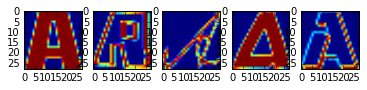

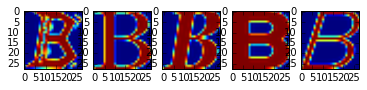

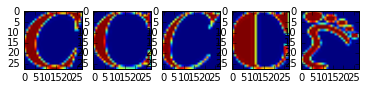

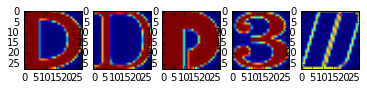

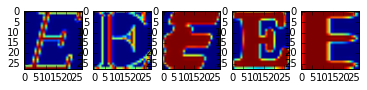

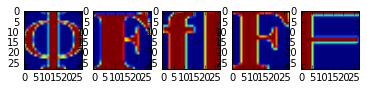

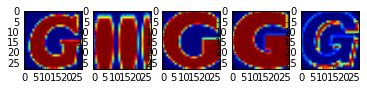

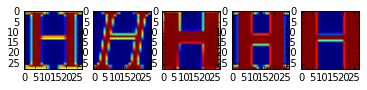

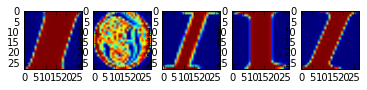

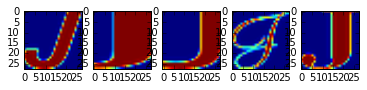

In [16]:
plot_samples(train_datasets)

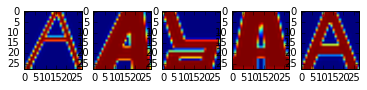

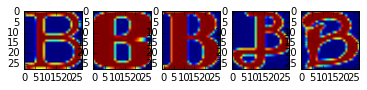

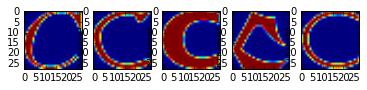

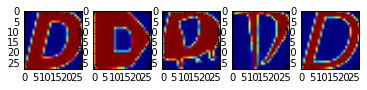

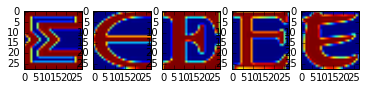

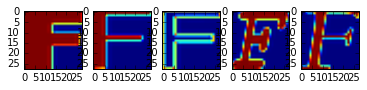

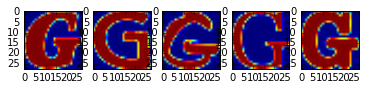

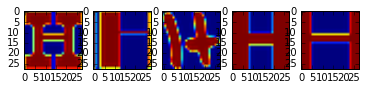

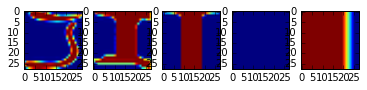

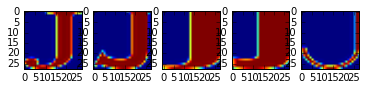

In [17]:
plot_samples(test_datasets)

---
Problem 3
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

Vincent said that we expect the classes to be roughly balanced in terms of number of images in each class (i.e. for each letter). So I'll simply count the number of images in each class to check if the data are balanced across classes.

In [18]:
def count_dataset(datasets):    
    for pickle_filename in datasets:
        with open(pickle_filename, 'r') as f:
            dataset = pickle.load(f)
        print("In '%s', we have %d datasets" % (pickle_filename, len(dataset)))


In [19]:
count_dataset(test_datasets)

In 'notMNIST_small/A.pickle', we have 1872 datasets
In 'notMNIST_small/B.pickle', we have 1873 datasets
In 'notMNIST_small/C.pickle', we have 1873 datasets
In 'notMNIST_small/D.pickle', we have 1873 datasets
In 'notMNIST_small/E.pickle', we have 1873 datasets
In 'notMNIST_small/F.pickle', we have 1872 datasets
In 'notMNIST_small/G.pickle', we have 1872 datasets
In 'notMNIST_small/H.pickle', we have 1872 datasets
In 'notMNIST_small/I.pickle', we have 1872 datasets
In 'notMNIST_small/J.pickle', we have 1872 datasets


In [20]:
count_dataset(train_datasets)

In 'notMNIST_large/A.pickle', we have 52909 datasets
In 'notMNIST_large/B.pickle', we have 52911 datasets
In 'notMNIST_large/C.pickle', we have 52912 datasets
In 'notMNIST_large/D.pickle', we have 52911 datasets
In 'notMNIST_large/E.pickle', we have 52912 datasets
In 'notMNIST_large/F.pickle', we have 52912 datasets
In 'notMNIST_large/G.pickle', we have 52912 datasets
In 'notMNIST_large/H.pickle', we have 52912 datasets
In 'notMNIST_large/I.pickle', we have 52912 datasets
In 'notMNIST_large/J.pickle', we have 52911 datasets


Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [22]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels  = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  # Get the number of classes (i.e. number of different letters) by counting the number of picke files 
  number_of_classes = len(pickle_files)
    
  train_dataset, train_labels = make_arrays(train_size, image_size)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
    
  # Get the number of samples per class (// truncate to integer)  
  train_size_per_class = train_size // number_of_classes
  valid_size_per_class = valid_size // number_of_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = valid_size_per_class, train_size_per_class
  end_l = valid_size_per_class+train_size_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        
        if valid_dataset is not None:
          valid_dataset[start_v:end_v, :, :] = letter_set[:valid_size_per_class, :, :]
          valid_labels[start_v:end_v] = label

          start_v += valid_size_per_class
          end_v   += valid_size_per_class
                    
        train_dataset[start_t:end_t, :, :] = letter_set[valid_size_per_class:end_l, :, :]
        train_labels[start_t:end_t] = label

        start_t += train_size_per_class
        end_t   += train_size_per_class

    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels

In [24]:
train_size = 200000
valid_size =  10000
test_size  =  10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('training dataset shape:   ', train_dataset.shape, "  training labels shape:   ", train_labels.shape)
print('validation dataset shape: ', valid_dataset.shape, "  validation labels shape: ", valid_labels.shape)
print('testing dataset shape:    ', test_dataset.shape,  "  testing labels shape:    ", test_labels.shape)

training dataset shape:    (200000, 28, 28)   training labels shape:    (200000,)
validation dataset shape:  (10000, 28, 28)   validation labels shape:  (10000,)
testing dataset shape:     (10000, 28, 28)   testing labels shape:     (10000,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [25]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels

train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset,  test_labels  = randomize(test_dataset,  test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

---
Problem 4
---------
Convince yourself that the data is still good after shuffling!

---

In [32]:
from collections import Counter

def count_dataset2(name, label):    
    print("In '%s', we have %s label" % (name, Counter(label)))


In [33]:
count_dataset2("train_dataset", train_labels)
count_dataset2("test_dataset",  test_labels)
count_dataset2("valid_dataset", valid_labels)

In 'train_dataset', we have Counter({0: 20000, 1: 20000, 2: 20000, 3: 20000, 4: 20000, 5: 20000, 6: 20000, 7: 20000, 8: 20000, 9: 20000}) label
In 'test_dataset', we have Counter({0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000, 6: 1000, 7: 1000, 8: 1000, 9: 1000}) label
In 'valid_dataset', we have Counter({0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000, 6: 1000, 7: 1000, 8: 1000, 9: 1000}) label


In [38]:
def plot_samples2(dataset, label):

    sample = np.random.choice(len(dataset), 10)
    for i, k in enumerate(sample):
        plt.subplot(2, 5, i+1)
        plt.title(chr(label[k] + ord('A')))
        plt.imshow(dataset[k])            


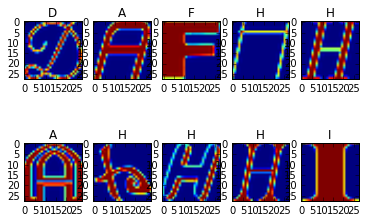

In [39]:
plot_samples2(train_dataset, train_labels)

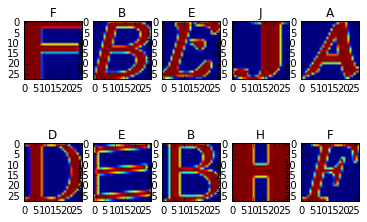

In [40]:
plot_samples2(test_dataset, test_labels)

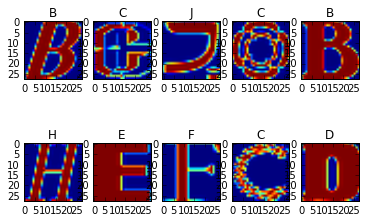

In [41]:
plot_samples2(valid_dataset, valid_labels)

Finally, let's save the data for later reuse:

In [42]:
pickle_file = 'notMNIST.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels':  train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels':  valid_labels,
    'test_dataset':  test_dataset,
    'test_labels':   test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [43]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800441


---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

In [62]:

def find_overlapping_samples(big_dataset, big_labels, small_dataset, small_labels):
    """
    big_dataset has to be bigger than small_dataset
    """
    # Sum up the number of images in each dataset.
    # shape gives 3 values, the first one (i.e. [O] is the size of the array), the other ones are the sizes of each image
    total_items = big_dataset.shape[0] + small_dataset.shape[0]
    overlapping_samples = 0
    
    # Walk through all the classes (a total of 10)
    for l in range(10):
        # Check only items with same labels
        # (big_labels == l) creates an array of boolean of the size of big_labels
        idx1 = (big_labels == l)
        idx2 = (small_labels == l)
        
        # With idx1 as an array of boolean, m1 will be an sub-array of big_dataset with only the element which are true in idx1
        m1 = big_dataset[idx1]
        m2 = small_dataset[idx2]
        
        for it1 in m1:
            overlapping_samples += np.sum(np.sum(np.abs(m2 - it1), axis=(-1,-2)) == 0)
            
    return overlapping_samples * 100.0 / total_items



In [63]:
print("train dataset size:", len(train_dataset))
print("valid dataset size:", len(valid_dataset))
print("test dataset size:",  len(test_dataset))


train dataset size: 200000
valid dataset size: 10000
test dataset size: 10000


In [64]:
print("Overlapping samples between Validation and Test: ", 
      find_overlapping_samples(valid_dataset, valid_labels, test_dataset, test_labels), "%")

Overlapping samples between Validation and Test:  59.02


In [65]:
print("Overlapping samples between Validation and Train: ", 
      find_overlapping_samples(train_dataset, train_labels, valid_dataset, valid_labels), "%")

Overlapping samples between Validation and Train:  90.6552380952


In [66]:
print("Overlapping samples between Test and Train: ", 
      find_overlapping_samples(train_dataset, train_labels, test_dataset, test_labels), "%")

Overlapping samples between Test and Train:  122.721428571


---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

First, visit the [web page of Sklearn on LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).


In [ ]:
from sklearn.linear_model import LogisticRegression

logistic_regression_classifier = LogisticRegression()